# Titanic survival prediction

## Libraries and settings

In [1]:
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

## Importing the data

In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

Data is divided into training and test set. First five rows of each one:

In [3]:
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
test_data.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

### Variable dictionary

| Variable | Definition Key |
| - | - |
Survival | Survival 0 = No, 1 = Yes
Pclass | Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
Sex | Male or Female
Age | Age in years
SibSp | # of siblings / spouses aboard the Titanic
Parch | # of parents / children aboard the Titanic
Ticket | Ticket number
Fare | Passenger fare
Cabin | Cabin number
Embarked | Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

In [5]:
def find_missing_data(df):
    counts_missing = df.isnull().sum()
    counts_total = df.isnull().count()
    percent_missing = (
        counts_missing / counts_total * 100
    )
    missing_table = pd.concat(
        [counts_missing, percent_missing],
        axis=1,
        keys=["Counts_missing", "Percent_missing"]
    )
    missing_table = missing_table[
        missing_table["Percent_missing"] > 0
    ].sort_values(by="Percent_missing", ascending=False)
    plt.bar(height=missing_table["Percent_missing"],
            x=missing_table.index)
    plt.xlabel("Feature")
    plt.ylabel("% missing data")
    return missing_table

Counts_missing  Percent_missing
Cabin                687        77.104377
Age                  177        19.865320
Embarked               2         0.224467

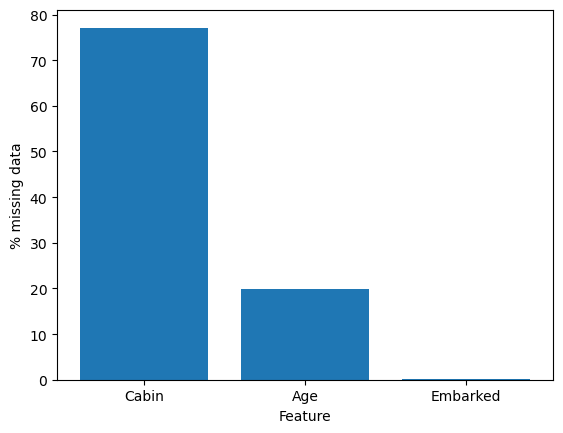

In [6]:
find_missing_data(train_data)

Counts_missing  Percent_missing
Cabin             327        78.229665
Age                86        20.574163
Fare                1         0.239234

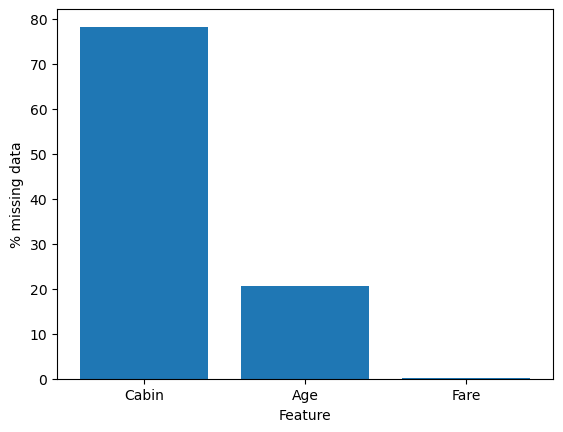

In [7]:
find_missing_data(test_data)

Preprocessing the data:

In [8]:
def preprocess(df):
    """Function for preprocessing raw titanic data."""
    # FILL NA VALUES
    # fill Embarked NA with mode (categorical var)
    if "Embarked" in df:
        df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)
    # fill Fare NA with median
    df["Fare"].fillna(df["Fare"].median(), inplace=True)
    # fill Age NA with median
    df["Age"].fillna(df["Age"].median(), inplace=True)

    # ADD NEW FEATURES
    # add FamilySize var (+1 is passenger themself)
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

    # CLEAN UP CERTAIN FEATURES
    # get Title from Name using regex
    if "Name" in df:
        df["Title"] = df["Name"].apply(
            lambda name: re.search('([A-Za-z]+)\.', name).group(1)
            if re.search('([A-Za-z]+)\.', name) else ""
        )
        df["Title"] = df["Title"].replace(
            ["Lady", "Countess", "Capt",
            "Col", "Don", "Dr", "Major",
            "Rev", "Sir", "Jonkheer", "Dona"],
            "Rare"
        )
        df["Title"] = df["Title"].replace("Mlle", "Miss")
        df["Title"] = df["Title"].replace("Ms", "Miss")
        df["Title"] = df["Title"].replace("Mme", "Mrs")
    # extract ticket number
    def extract_ticket_number(ticket):
        try:
            return int(ticket.split(" ")[-1])
        except ValueError:
            return 0
    if "Ticket" in df:
        df["TicketNumber"] = df["Ticket"].apply(extract_ticket_number)

    # DROP UNWANTED FEATURES
    # >75 % missing data --> dropping Cabin
    # dropping Name: we do not need it anymore
    drop_feats = ["Cabin", "Name", "Ticket"]
    if df.columns.isin(drop_feats).any():
        df.drop(columns=drop_feats, inplace=True)

    # CHANGE ALL VALUES TO NUMERICAL
    df = pd.get_dummies(df)
    return df

train_data = preprocess(train_data)
test_data = preprocess(test_data)

Checking if data is balanced:

In [9]:
vcounts_before = train_data.Survived.value_counts()
vcounts_before

0    549
1    342
Name: Survived, dtype: int64

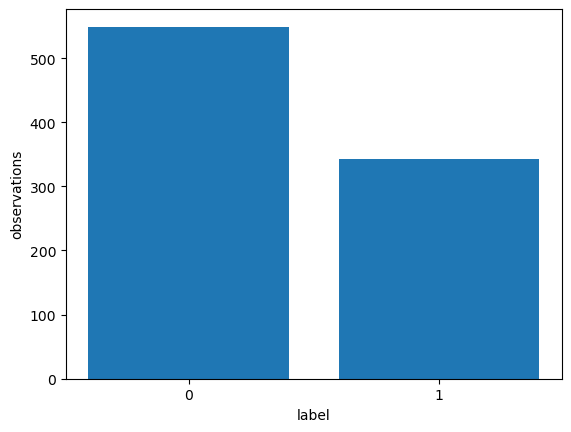

In [10]:
plt.bar(height=vcounts_before, x=["0", "1"])
plt.xlabel("label")
plt.ylabel("observations")
plt.show()

As seen above, data is unbalanced (there is more observations with label "0" than with label "1"). In order to balance it out I use simple resampling:

In [11]:
resampled_train_data = train_data[train_data.Survived == 1].sample(
    n=abs(vcounts_before[0] - vcounts_before[1])
)
balanced_train_data = pd.concat([train_data, resampled_train_data])

In [12]:
vcounts_after = balanced_train_data.Survived.value_counts()
vcounts_after

0    549
1    549
Name: Survived, dtype: int64

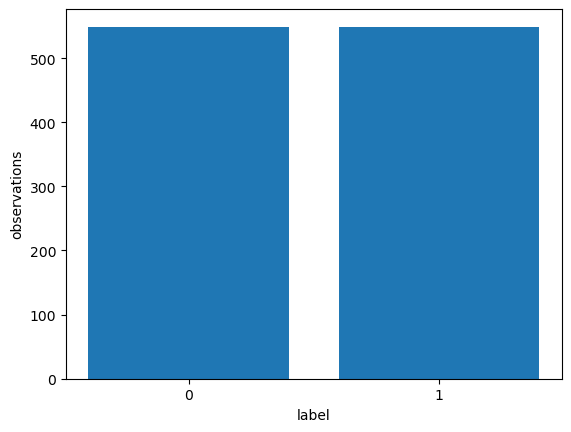

In [13]:
plt.bar(height=vcounts_after, x=["0", "1"])
plt.xlabel("label")
plt.ylabel("observations")
plt.show()

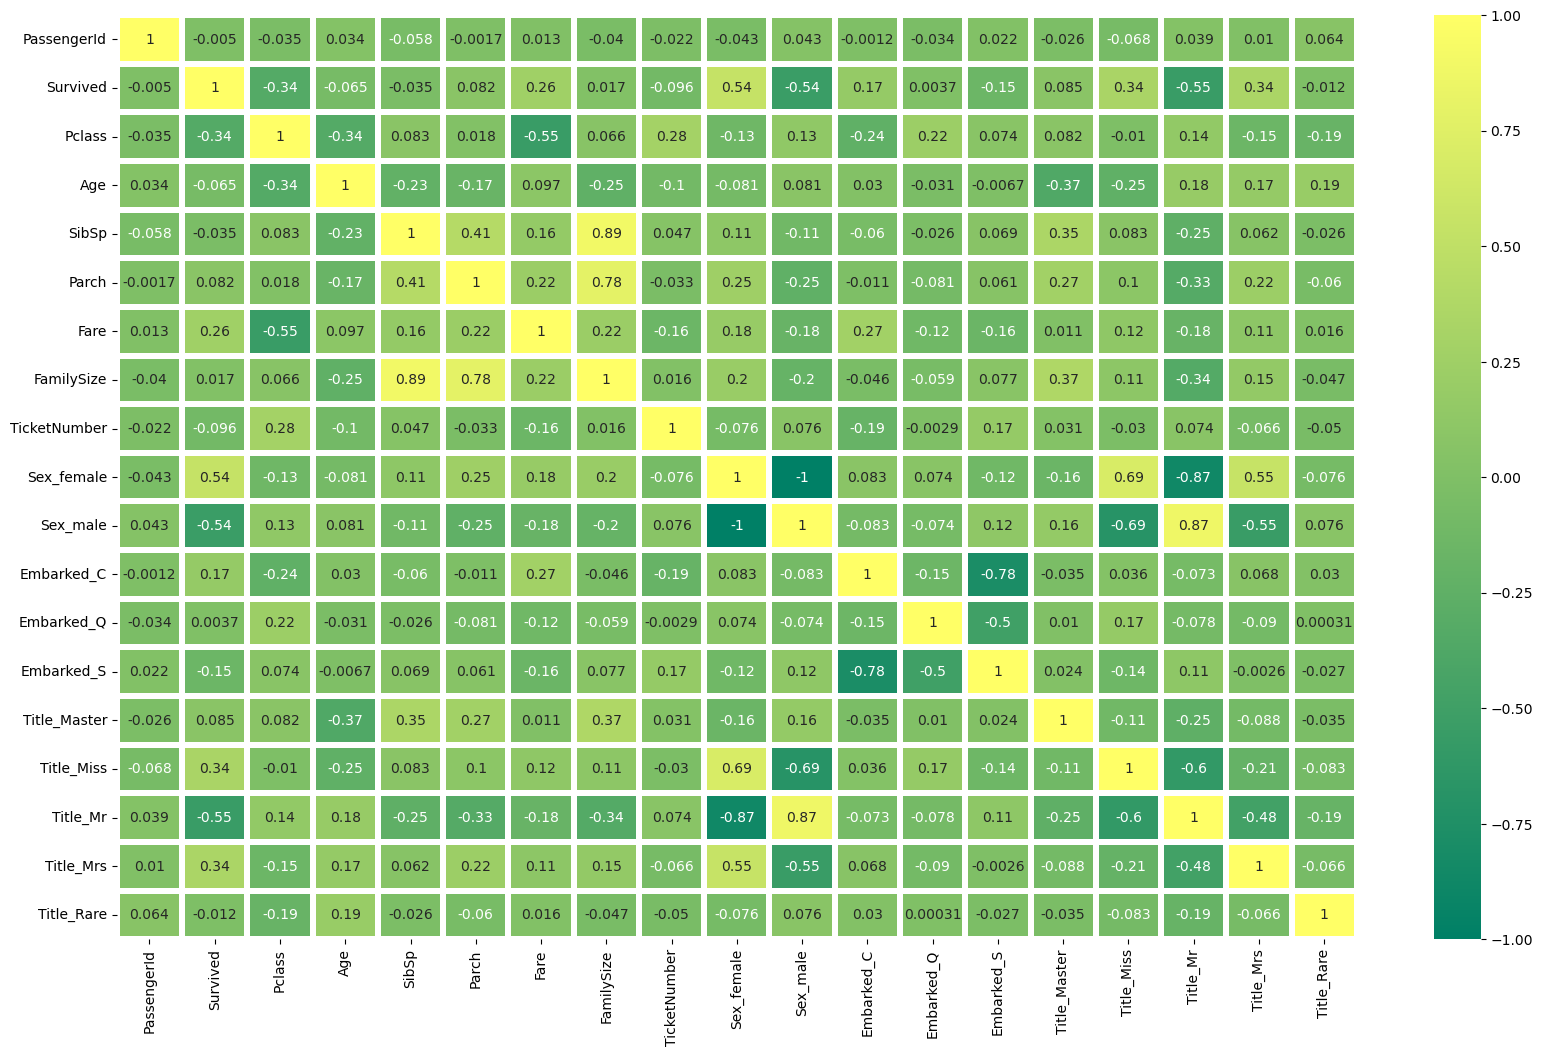

In [14]:
sns.heatmap(train_data.corr(), cmap="summer", annot=True, linewidths=3)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

Pairplot visualisation to get better overview of dependencies in the training dataset.

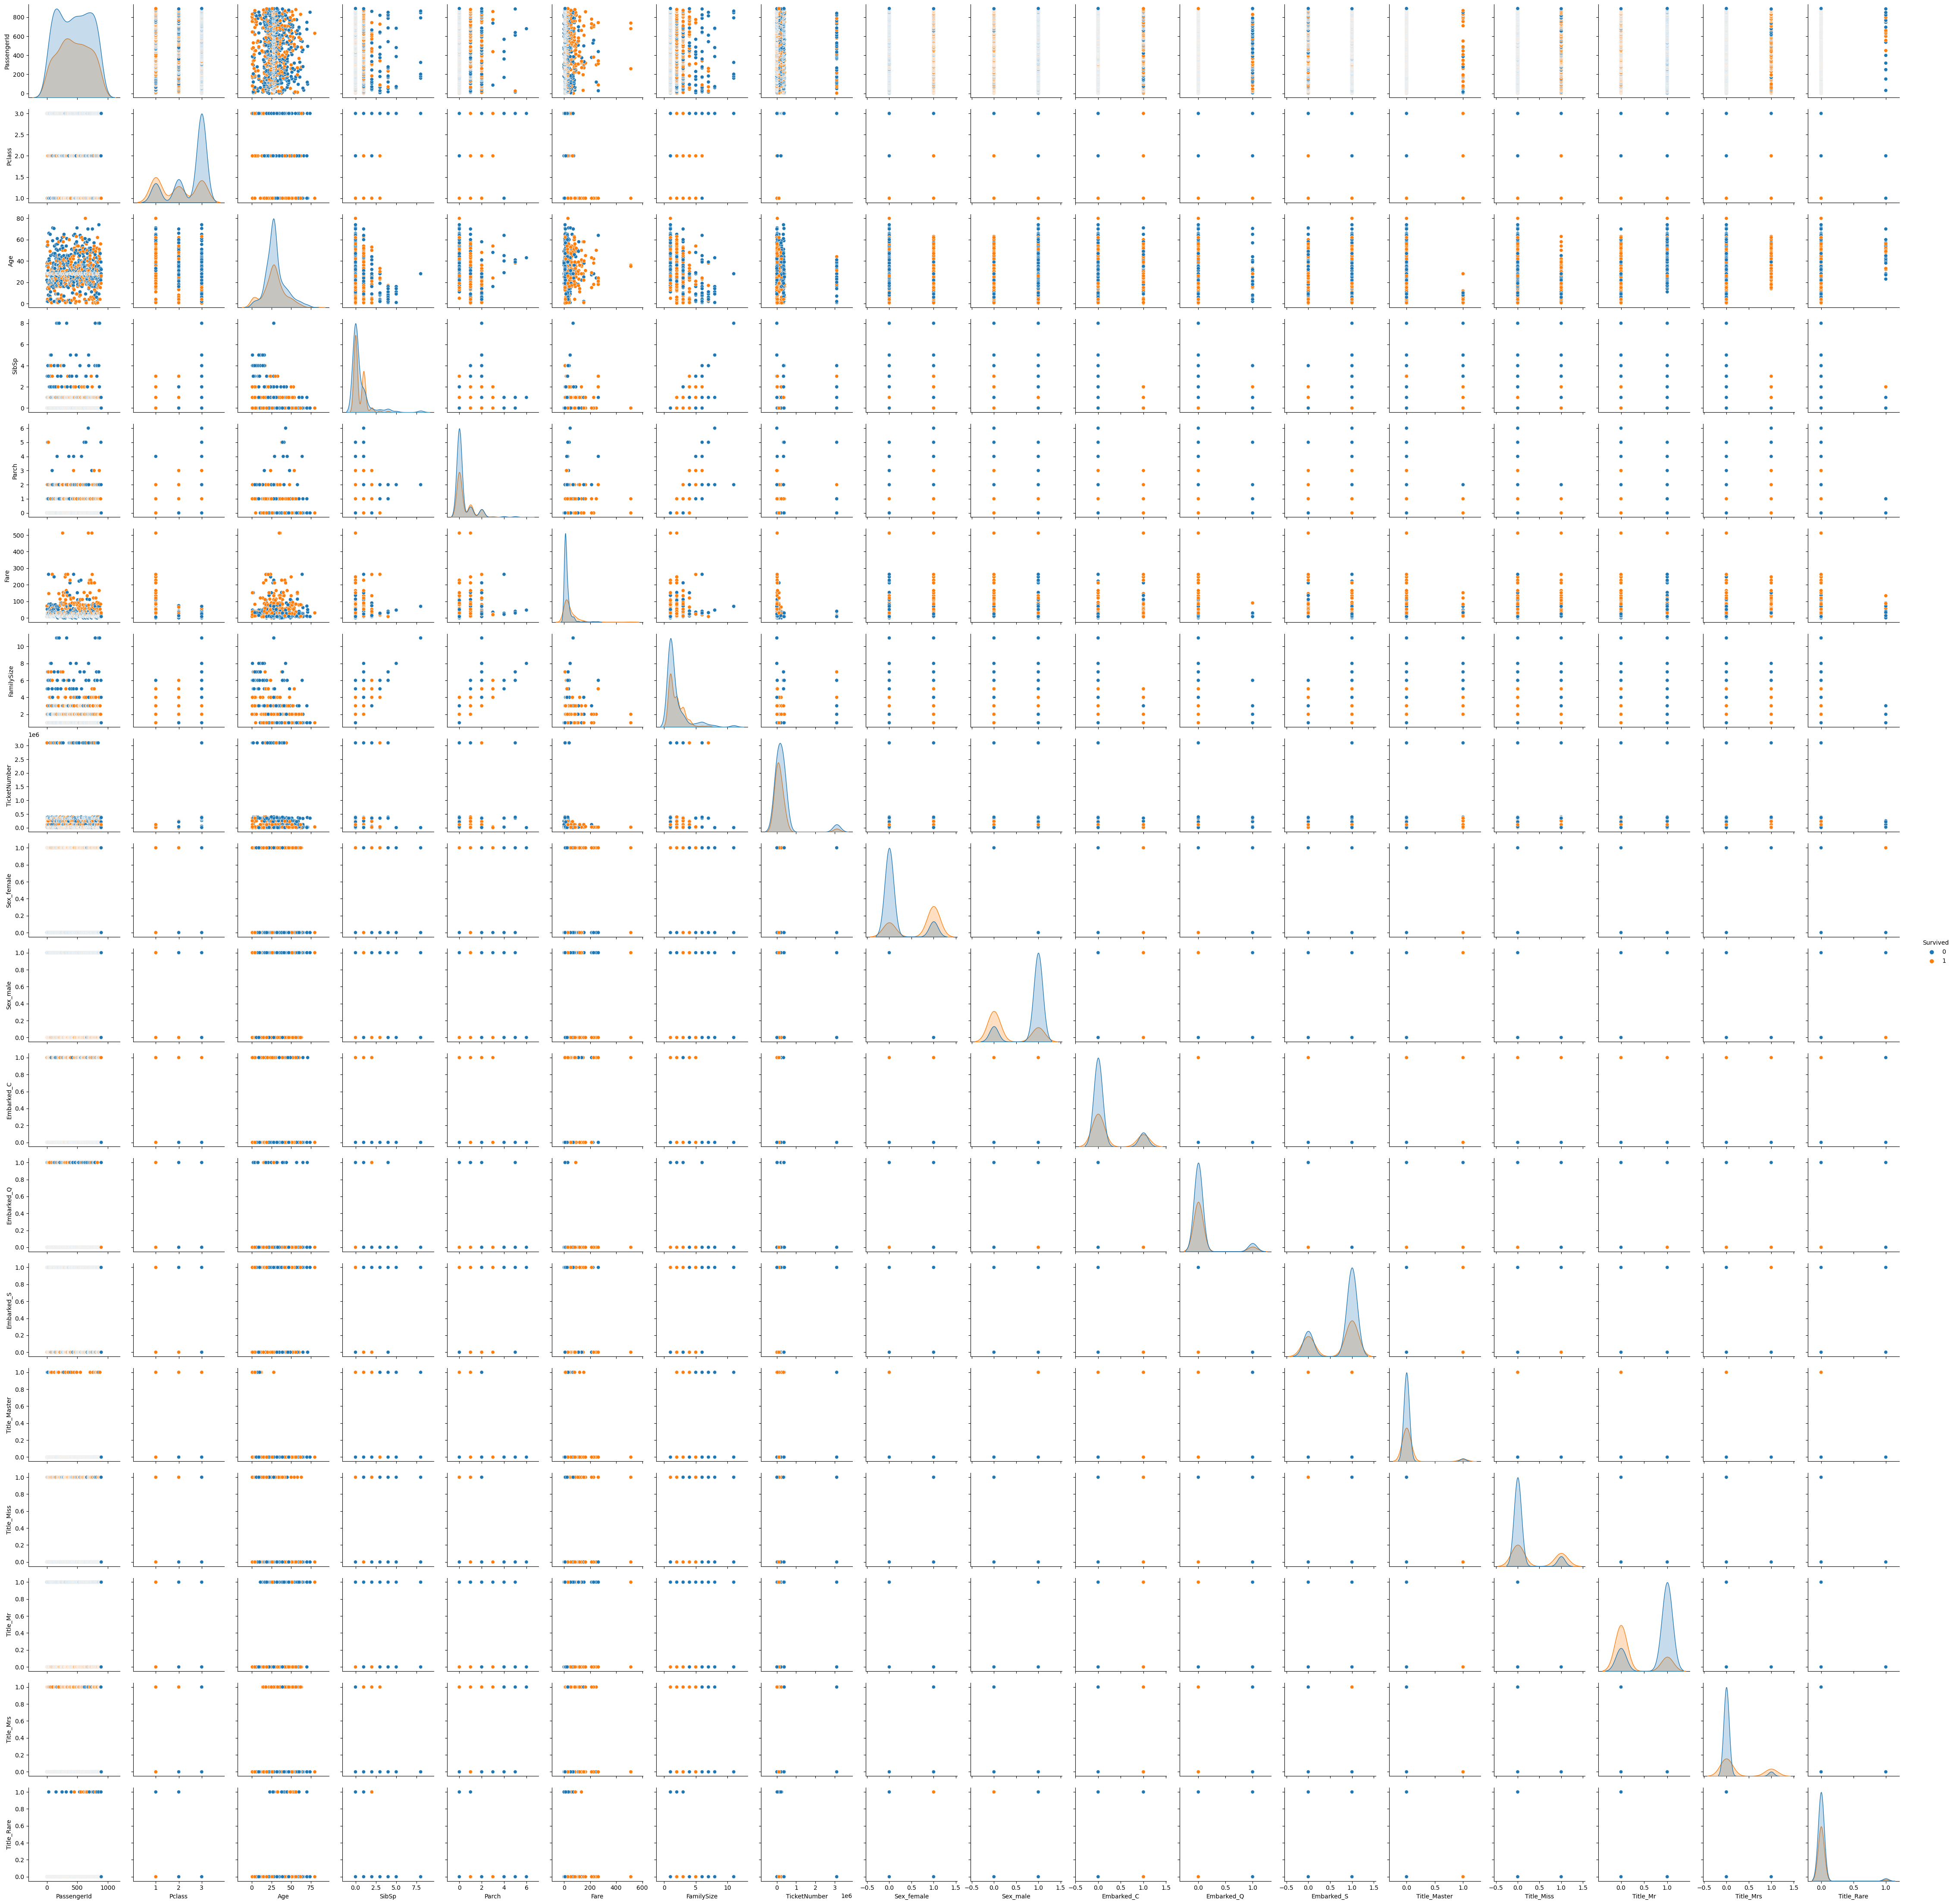

In [15]:
sns.pairplot(train_data.iloc[:, :], hue = 'Survived', diag_kind='kde');

Splitting data into $X$ and $Y$:

In [16]:
train_x = np.array(balanced_train_data.drop(columns=["Survived", "PassengerId"]))
train_y = np.array(balanced_train_data["Survived"])
test_x = np.array(test_data.drop(columns="PassengerId"))

train_x, valid_x, train_y, valid_y = train_test_split(
    train_x, train_y, test_size=0.15, random_state=1
)

## Logistic regression

Creating a check pipeline with no hyperparameters:

In [17]:
empty_lrc = make_pipeline(
    StandardScaler(),
    LogisticRegression()
) # estimator

for i in empty_lrc.get_params().items():
    print(i)

('memory', None)
('steps', [('standardscaler', StandardScaler()), ('logisticregression', LogisticRegression())])
('verbose', False)
('standardscaler', StandardScaler())
('logisticregression', LogisticRegression())
('standardscaler__copy', True)
('standardscaler__with_mean', True)
('standardscaler__with_std', True)
('logisticregression__C', 1.0)
('logisticregression__class_weight', None)
('logisticregression__dual', False)
('logisticregression__fit_intercept', True)
('logisticregression__intercept_scaling', 1)
('logisticregression__l1_ratio', None)
('logisticregression__max_iter', 100)
('logisticregression__multi_class', 'auto')
('logisticregression__n_jobs', None)
('logisticregression__penalty', 'l2')
('logisticregression__random_state', None)
('logisticregression__solver', 'lbfgs')
('logisticregression__tol', 0.0001)
('logisticregression__verbose', 0)
('logisticregression__warm_start', False)


In [18]:
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

param_grid = [{
    "logisticregression__multi_class": [
        "auto",
        "ovr",
        "multinomial"
    ],
    "logisticregression__C": param_range,
    "logisticregression__tol": param_range,
    "logisticregression__max_iter": [
        10**4,
        10**5
    ],
    "logisticregression__solver": [
        "lbfgs",
        "liblinear",
        "sag",
        "saga"
    ],
}]

grid_search = GridSearchCV(
    estimator=empty_lrc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,  # cross validation
    n_jobs=-1
)

grid_search = grid_search.fit(train_x, train_y)
grid_search.best_params_

{'logisticregression__C': 10.0,
 'logisticregression__max_iter': 10000,
 'logisticregression__multi_class': 'ovr',
 'logisticregression__solver': 'saga',
 'logisticregression__tol': 1.0}

In [19]:
grid_search.best_score_

0.8199725463280714

Visualising model performance using a confusion matrix:

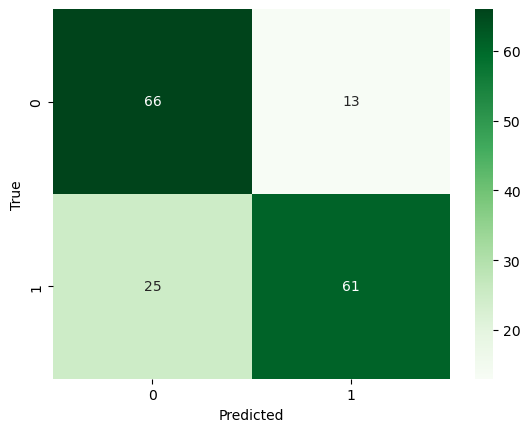

In [20]:
pred_y = grid_search.best_estimator_.predict(valid_x)
cm = confusion_matrix(valid_y, pred_y)
sns.heatmap(cm, annot=True, cmap="Greens")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

Classification report:

In [21]:
print(classification_report(valid_y, pred_y))

              precision    recall  f1-score   support

           0       0.73      0.84      0.78        79
           1       0.82      0.71      0.76        86

    accuracy                           0.77       165
   macro avg       0.77      0.77      0.77       165
weighted avg       0.78      0.77      0.77       165



Training a model again on a full training set to obtain better accuracy:

In [22]:
train_x = np.array(balanced_train_data.drop(columns=["Survived", "PassengerId"]))
train_y = np.array(balanced_train_data["Survived"])
lrc = grid_search.fit(train_x, train_y)
lrc.best_score_

0.8114678899082568

Making a prediction:

In [23]:
pred_y = lrc.best_estimator_.predict(test_x)
output = pd.DataFrame({"PassengerID": test_data["PassengerId"],
                       "Survived": pred_y})
output.to_csv("output/titanic-lrc.csv", index=False)

## Random Forest

In [24]:
empty_rfc = make_pipeline(
    StandardScaler(),
    RandomForestClassifier()
) # estimator

for i in empty_rfc.get_params().items():
    print(i)

('memory', None)
('steps', [('standardscaler', StandardScaler()), ('randomforestclassifier', RandomForestClassifier())])
('verbose', False)
('standardscaler', StandardScaler())
('randomforestclassifier', RandomForestClassifier())
('standardscaler__copy', True)
('standardscaler__with_mean', True)
('standardscaler__with_std', True)
('randomforestclassifier__bootstrap', True)
('randomforestclassifier__ccp_alpha', 0.0)
('randomforestclassifier__class_weight', None)
('randomforestclassifier__criterion', 'gini')
('randomforestclassifier__max_depth', None)
('randomforestclassifier__max_features', 'auto')
('randomforestclassifier__max_leaf_nodes', None)
('randomforestclassifier__max_samples', None)
('randomforestclassifier__min_impurity_decrease', 0.0)
('randomforestclassifier__min_impurity_split', None)
('randomforestclassifier__min_samples_leaf', 1)
('randomforestclassifier__min_samples_split', 2)
('randomforestclassifier__min_weight_fraction_leaf', 0.0)
('randomforestclassifier__n_estimator

In [25]:
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

param_grid = [{
    "randomforestclassifier__n_estimators": [
        # 100,
        # 1000,
        10**4
    ],
    "randomforestclassifier__max_depth": [
        # 1,
        5,
        # 10,
        # 100
    ]
}]

grid_search = GridSearchCV(
    estimator=empty_rfc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,  # cross validation
    n_jobs=-1
)

grid_search = grid_search.fit(train_x, train_y)
grid_search.best_params_

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__n_estimators': 10000}

In [26]:
grid_search.best_score_

0.8160050041701418

Confusion matrix:

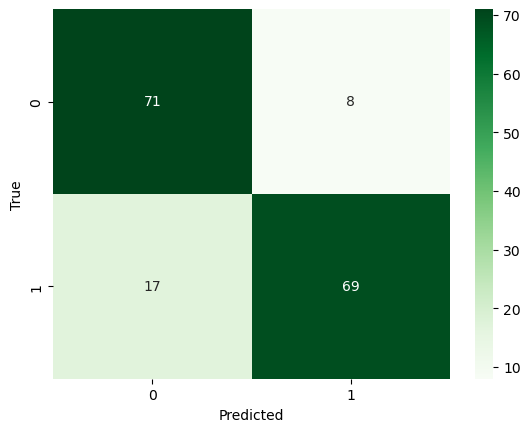

In [27]:
pred_y = grid_search.best_estimator_.predict(valid_x)
cm = confusion_matrix(valid_y, pred_y)
sns.heatmap(cm, annot=True, cmap="Greens")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

Classification report:

In [28]:
print(classification_report(valid_y, pred_y))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85        79
           1       0.90      0.80      0.85        86

    accuracy                           0.85       165
   macro avg       0.85      0.85      0.85       165
weighted avg       0.85      0.85      0.85       165



Training on a full training set:

In [29]:
train_x = np.array(balanced_train_data.drop(columns=["Survived", "PassengerId"]))
train_y = np.array(balanced_train_data["Survived"])
lrc = grid_search.fit(train_x, train_y)
lrc.best_score_

0.8150959132610508

Prediction:

In [30]:
pred_y = lrc.best_estimator_.predict(test_x)
output = pd.DataFrame({"PassengerID": test_data["PassengerId"],
                       "Survived": pred_y})
output.to_csv("output/titanic-rfc.csv", index=False)